In [4]:
import pandas as pd
import numpy as np
file_path ='./cafedata/jeju-pricedata.csv'
df = pd.read_csv(file_path)
df.head()

,뚜레쥬르 지점,뚜레쥬르 서귀포동홍,뚜레쥬르 서귀포,뚜레쥬르 제주노형타운,뚜레쥬르 제주연오로,뚜레쥬르 제주남녕,뚜레쥬르 제주노형오거리,뚜레쥬르 제주중앙병원
0,마늘 단짝 고구마,4900.0,4900.0,4900.0,NaN,4900.0,4900.0,4900.0
1,깊은 밤 뺑스위스,4300.0,4300.0,4300.0,NaN,4300.0,4300.0,4300.0
2,BELT 샌드위치,6900.0,6900.0,6900.0,NaN,6900.0,NaN,6900.0
3,BLT콥 샐러드,NaN,NaN,NaN,NaN,NaN,NaN,8500.0
4,쉬림프 에그 샐러드,NaN,10500.0,NaN,NaN,NaN,NaN,10500.0


In [10]:
import re

def categorize_menu(df):
    # 키워드 기반 카테고리 매핑 딕셔너리
    category_keywords = {
        '샌드위치류': ['샌드위치', 'BELT', 'BLT', 'V.E.L.T'],
        '샐러드류': ['샐러드'],
        '식빵류': ['식빵', '우유롤', '우유 브레드', '소버식빵'],
        '크림빵': ['크림가득 메론빵','마담 얼그레이 크림번','순진우유크림빵','겹겹이 연유 크림 데니쉬','사르르 고구마케이크빵','사르르 우유크림빵','빵속에리얼초코','카페모카크림빵','까까웨뜨'],
        '피자빵,고로케': ['고로케', '소시지브레드','피자토스트','NEW어니언소시지포카치아'],
        '파이/패스트리': ['바통쉬크레','크라상','애플파이','유자파이'],
        '간식빵': ['소금버터롤','치즈방앗간','깨찰빵','소보로빵','오리지널 커피번','카페모카빵','꽈배기','옛날 단팥 도넛',r'^단팥빵$','단팥소보로빵'],
        '신제품': ['마구마구', '단짝', '뺑스위스']
    }
    
    # 새로운 카테고리 컬럼 생성
    df['카테고리'] = '기타'  # 기본값
    
    # 각 메뉴명에 대해 카테고리 매핑
    for idx, menu_name in enumerate(df['뚜레쥬르 지점']):
        if pd.isna(menu_name):  # null 체크
            continue
            
        menu_name = str(menu_name).lower()  # 소문자 변환
        
        # 각 카테고리의 키워드 체크
        for category, keywords in category_keywords.items():
            if any(keyword.lower() in menu_name for keyword in keywords):
                df.loc[idx, '카테고리'] = category
                break
    
    return df

def analyze_categories_by_store(df):
    # 매장별 카테고리별 기본 통계
    stores = df.columns[1:-1]  # 첫 번째 열(메뉴명)과 마지막 열(카테고리) 제외
    
    # 카테고리별 기본 통계
    category_stats = pd.DataFrame()
    
    for store in stores:
        # 매장별 데이터 숫자로 변환 (오류 방지)
        df[store] = pd.to_numeric(df[store], errors='coerce')
        
        temp = df.groupby('카테고리').agg({store: 'mean'})
        temp.reset_index(inplace=True)
        temp.rename(columns={store: '평균 가격'}, inplace=True)
        temp['매장명'] = store
        category_stats = pd.concat([category_stats, temp], axis=0)

    return category_stats

def pivot_store_category(stats):
    # 피벗 테이블 생성
    pivot_table = stats.pivot_table(index='매장명', columns='카테고리', values='평균 가격', aggfunc='mean')
    pivot_table=pivot_table.round(1)
    pivot_table.reset_index(inplace=True)
    return pivot_table

# 데이터 로드 및 처리
def process_bakery_data(filepath):
    # CSV 파일 읽기
    df = pd.read_csv(filepath)
    
    # 카테고리 지정
    df = categorize_menu(df)
    
    # 매장별 카테고리별 분석
    stats = analyze_categories_by_store(df)
    
    # 피벗 테이블 생성
    pivot_table = pivot_store_category(stats)
    
    return df, pivot_table

# 파일 처리 및 결과 생성
df, pivot_table = process_bakery_data(file_path)

# 카테고리화된 데이터 및 매장별 통계 표시
from IPython.display import display

# print("카테고리화된 가격 데이터 (처음 5개 행)")
# display(df.head())
########################################################################################################################

storeinfo_filepath='./뚜레쥬르_매장정보_제주도.csv'

def process_address(address):
    try:
        # 수동 수정
        if address == '경기도 동탄지성로469번길 60 5단지 상가1동107호,108호,109호':
            return '경기도 화성시'
   
        # 정규표현식으로 '충청남도 XX시' 추출
        match = re.match(r'제주특별자치도 \w+시', address) or re.match(r'제주특별자치도 \w+군', address) or re.match(r'제주특별자치도\s+\w+구', address)
        
        if match:
            return match.group()
        
        # 기본값 반환
        return address
    except Exception as e:
        print(f"주소 처리 중 오류 발생: {address}, {e}")
        return address

def load_store_info(storeinfo_filepath):
    store_info = pd.read_csv(storeinfo_filepath)
    # 주소 컬럼 처리
    store_info['주소'] = store_info['주소'].apply(process_address)
    return store_info



def process_bakery_data(price_filepath, store_info_filepath):
    # 가격 데이터 로드
    df = pd.read_csv(price_filepath)
    
    # 매장 정보 데이터 로드
    store_info = load_store_info(store_info_filepath)
    
    # 카테고리 지정
    df = categorize_menu(df)
    
    # 매장별 카테고리별 분석
    stats = analyze_categories_by_store(df)
    
    # 피벗 테이블 생성 후 매장 정보 병합
    pivot_table = pivot_store_category(stats)
    result = pd.merge(pivot_table, store_info, 
                     left_on='매장명', 
                     right_on='매장', 
                     how='left')
    
    # 컬럼 순서 재정렬
    columns = ['매장명', '주소', '지역'] + [col for col in result.columns 
              if col not in ['매장명', '매장', '주소', '지역']]
    result = result[columns]
    
    return df, result

# 실제 파일 경로로 호출
df, result = process_bakery_data('./cafedata/jeju-pricedata.csv', 
                                './adress_process/뚜레쥬르_매장정보_제주도_수정.csv')

# 결과 출력
print("\n매장별 카테고리별 평균 가격 (주소 정보 포함)")
display(result)


매장별 카테고리별 평균 가격 (주소 정보 포함)


,매장명,주소,지역,간식빵,기타,샌드위치류,샐러드류,식빵류,신제품,크림빵,파이/패스트리,"피자빵,고로케"
0,뚜레쥬르 서귀포,제주특별자치도 서귀포시,제주도,3290.9,4271.7,7166.7,8875.0,4952.9,4933.3,3314.3,2933.3,3300.0
1,뚜레쥬르 서귀포동홍,제주특별자치도 서귀포시,제주도,3227.3,4407.3,7033.3,8300.0,5118.2,4600.0,3366.7,2933.3,3125.0
2,뚜레쥬르 제주남녕,제주특별자치도 제주시,제주도,3000.0,3647.2,7050.0,8300.0,5038.5,4933.3,3416.7,2800.0,3120.0
3,뚜레쥬르 제주노형오거리,제주특별자치도 제주시,제주도,2733.3,4394.6,7100.0,NaN,5138.5,4600.0,3400.0,2400.0,3040.0
4,뚜레쥬르 제주노형타운,제주특별자치도 제주시,제주도,2440.0,4463.3,7060.0,NaN,5150.0,4600.0,3875.0,2933.3,3300.0
5,뚜레쥬르 제주연오로,제주특별자치도 제주시,제주도,2954.5,4014.6,7140.0,NaN,4880.0,5600.0,3600.0,2900.0,3180.0
6,뚜레쥬르 제주중앙병원,제주특별자치도 제주시,제주도,3140.0,4221.7,6608.3,9850.0,5511.1,4933.3,3425.0,3000.0,3220.0


In [11]:
grouped_data = result.groupby('주소')[['간식빵', '샌드위치류', '샐러드류', '식빵류', '신제품', '크림빵', '파이/패스트리', '피자빵,고로케']].mean().mean(axis=1).sort_values(ascending=False)

# groupby 결과를 데이터프레임으로 변환
grouped_df = pd.DataFrame(grouped_data).reset_index()

# 컬럼명 변경
grouped_df.columns = ['주소', '평균가격']

# CSV 파일로 저장
grouped_df.to_csv('anal_jeju/시별_빵_평균가격.csv', index=False, encoding='utf-8-sig')
grouped_df

,주소,평균가격
0,제주특별자치도 제주시,4814.8950
1,제주특별자치도 서귀포시,4779.3875


In [12]:
categories = ['간식빵', '샌드위치류', '샐러드류', '식빵류', '신제품', '크림빵', '파이/패스트리', '피자빵,고로케']

# 각 카테고리별로 구의 평균 가격 계산
grouped_data = {}
for category in categories:
    grouped_data[category] = result.groupby('주소')[category].mean().round(2)

# 데이터프레임 생성
grouped_df = pd.DataFrame(grouped_data)

# CSV 파일로 저장
grouped_df.to_csv('anal_jeju/시군별_카테고리_평균가격.csv', encoding='utf-8-sig')
grouped_df

,간식빵,샌드위치류,샐러드류,식빵류,신제품,크림빵,파이/패스트리,"피자빵,고로케"
주소,,,,,,,,
제주특별자치도 서귀포시,3259.10,7100.00,8587.5,5035.55,4766.65,3340.50,2933.30,3212.5
제주특별자치도 제주시,2853.56,6991.66,9075.0,5143.62,4933.32,3543.34,2806.66,3172.0


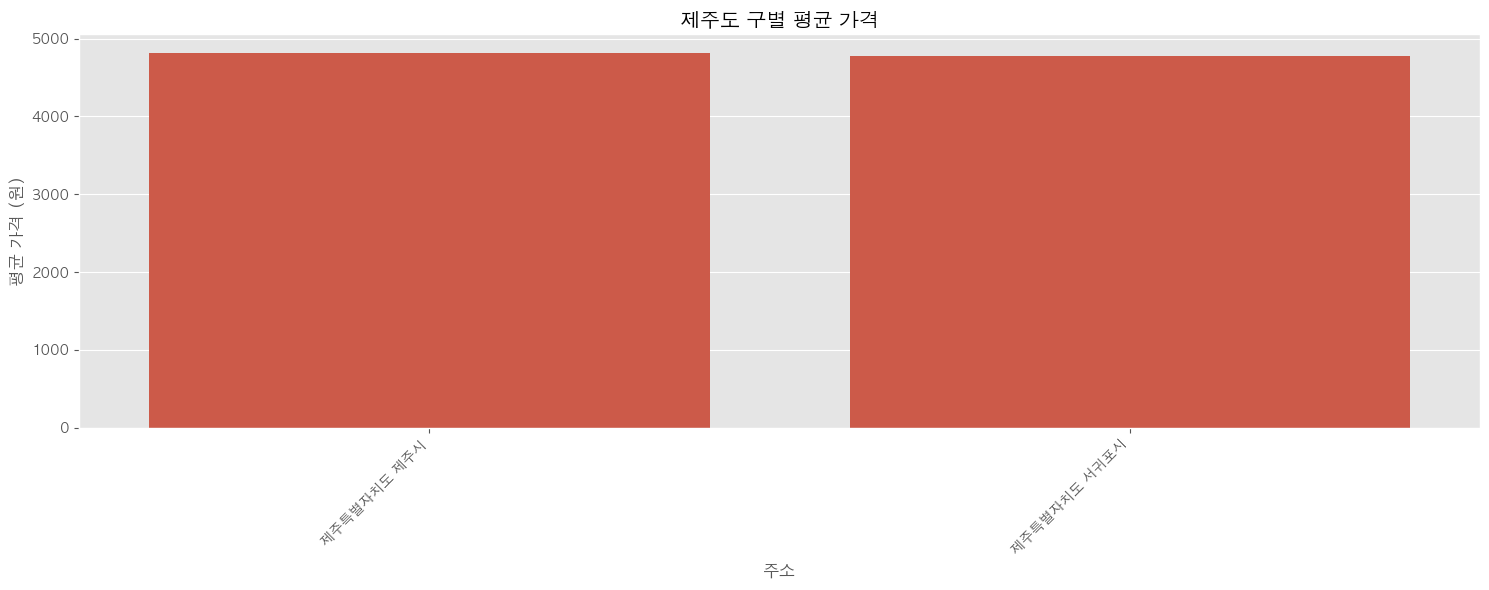

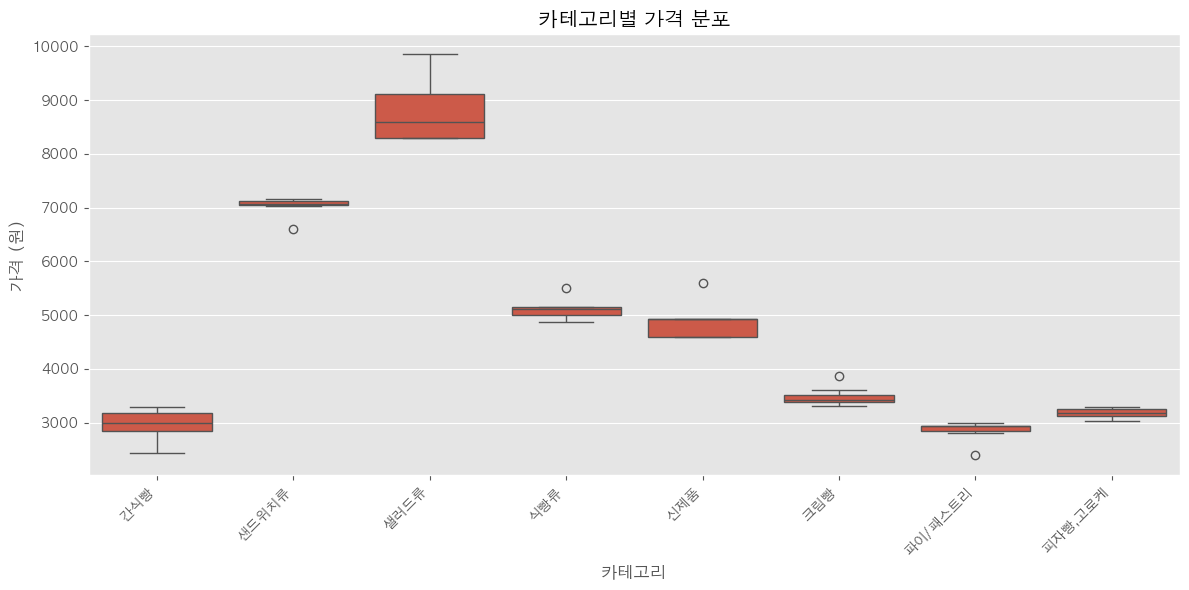

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import font_manager, rc

# Mac OS 용 폰트 설정
plt.rc('font', family='AppleGothic') # 맥용 폰트 설정

# 그래프 기본 설정
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')


# 1. 구별 전체 평균 가격 분석
plt.figure(figsize=(15, 6))
grouped_data = result.groupby('주소')[['간식빵', '샌드위치류', '샐러드류', '식빵류', '신제품', '크림빵', '파이/패스트리', '피자빵,고로케']].mean().mean(axis=1).sort_values(ascending=False)

sns.barplot(x=grouped_data.index, y=grouped_data.values)
plt.title('제주도 구별 평균 가격')
plt.xticks(rotation=45, ha='right')
plt.ylabel('평균 가격 (원)')
plt.tight_layout()
plt.show()

# 2. 카테고리별 가격 분포 (박스플롯)
plt.figure(figsize=(12, 6))
categories = ['간식빵', '샌드위치류', '샐러드류', '식빵류', '신제품', '크림빵', '파이/패스트리', '피자빵,고로케']
data_melted = pd.melt(result, value_vars=categories)

sns.boxplot(x='variable', y='value', data=data_melted)
plt.title('카테고리별 가격 분포')
plt.xticks(rotation=45, ha='right')
plt.xlabel('카테고리')
plt.ylabel('가격 (원)')
plt.tight_layout()
plt.show()

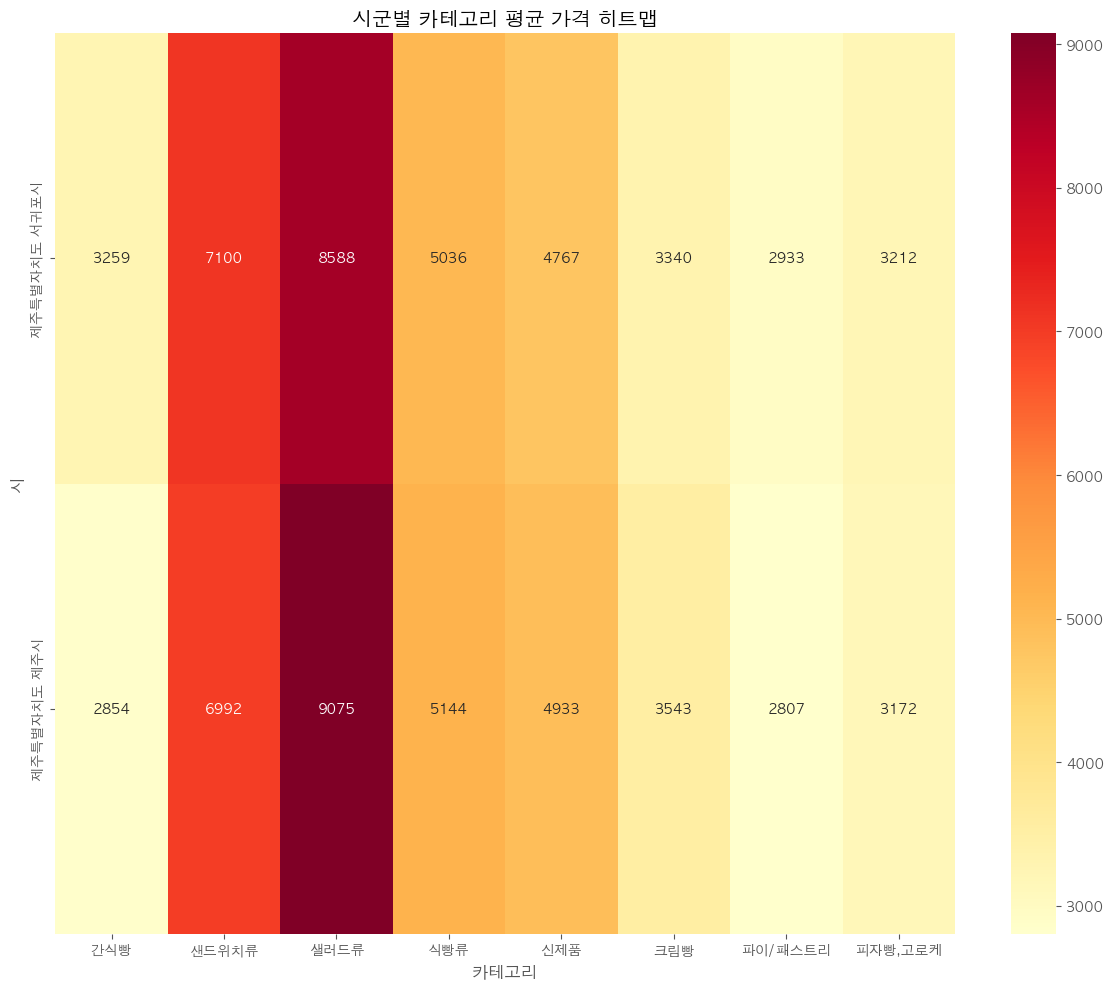

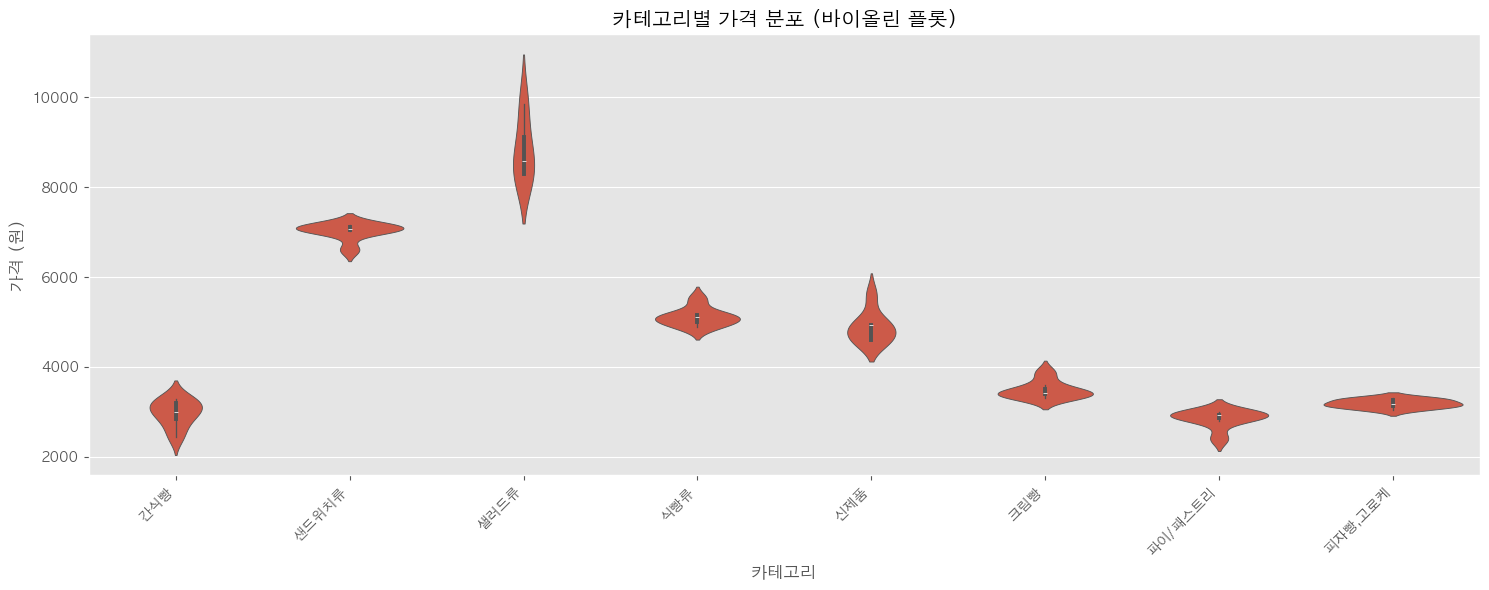

In [14]:

# 3. 구별/카테고리별 평균 가격 히트맵
plt.figure(figsize=(12, 10))
pivot_data = result.groupby('주소')[categories].mean()
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('시군별 카테고리 평균 가격 히트맵')
plt.ylabel('시')
plt.xlabel('카테고리')
plt.tight_layout()
plt.show()

# 5. 카테고리별 가격 분포 (바이올린 플롯)
plt.figure(figsize=(15, 6))
sns.violinplot(x='variable', y='value', data=data_melted)
plt.title('카테고리별 가격 분포 (바이올린 플롯)')
plt.xticks(rotation=45, ha='right')
plt.xlabel('카테고리')
plt.ylabel('가격 (원)')
plt.tight_layout()
plt.show()

전처리 후 구별 빵가격 데이터:
     구분     평균_빵가격
0  서귀포시  4779.3875
1   제주시  4814.8950

전처리 후 아파트 가격 데이터:
     구분      매매   전세
1  서귀포시  1284.0  811
2   제주시  1586.0  894

병합된 데이터:
     구분     평균_빵가격      매매
0  서귀포시  4779.3875  1284.0
1   제주시  4814.8950  1586.0

상관계수: 1.000
양의 상관관계가 있습니다: 아파트 가격이 높은 시일수록 빵 가격도 높은 경향이 있습니다.


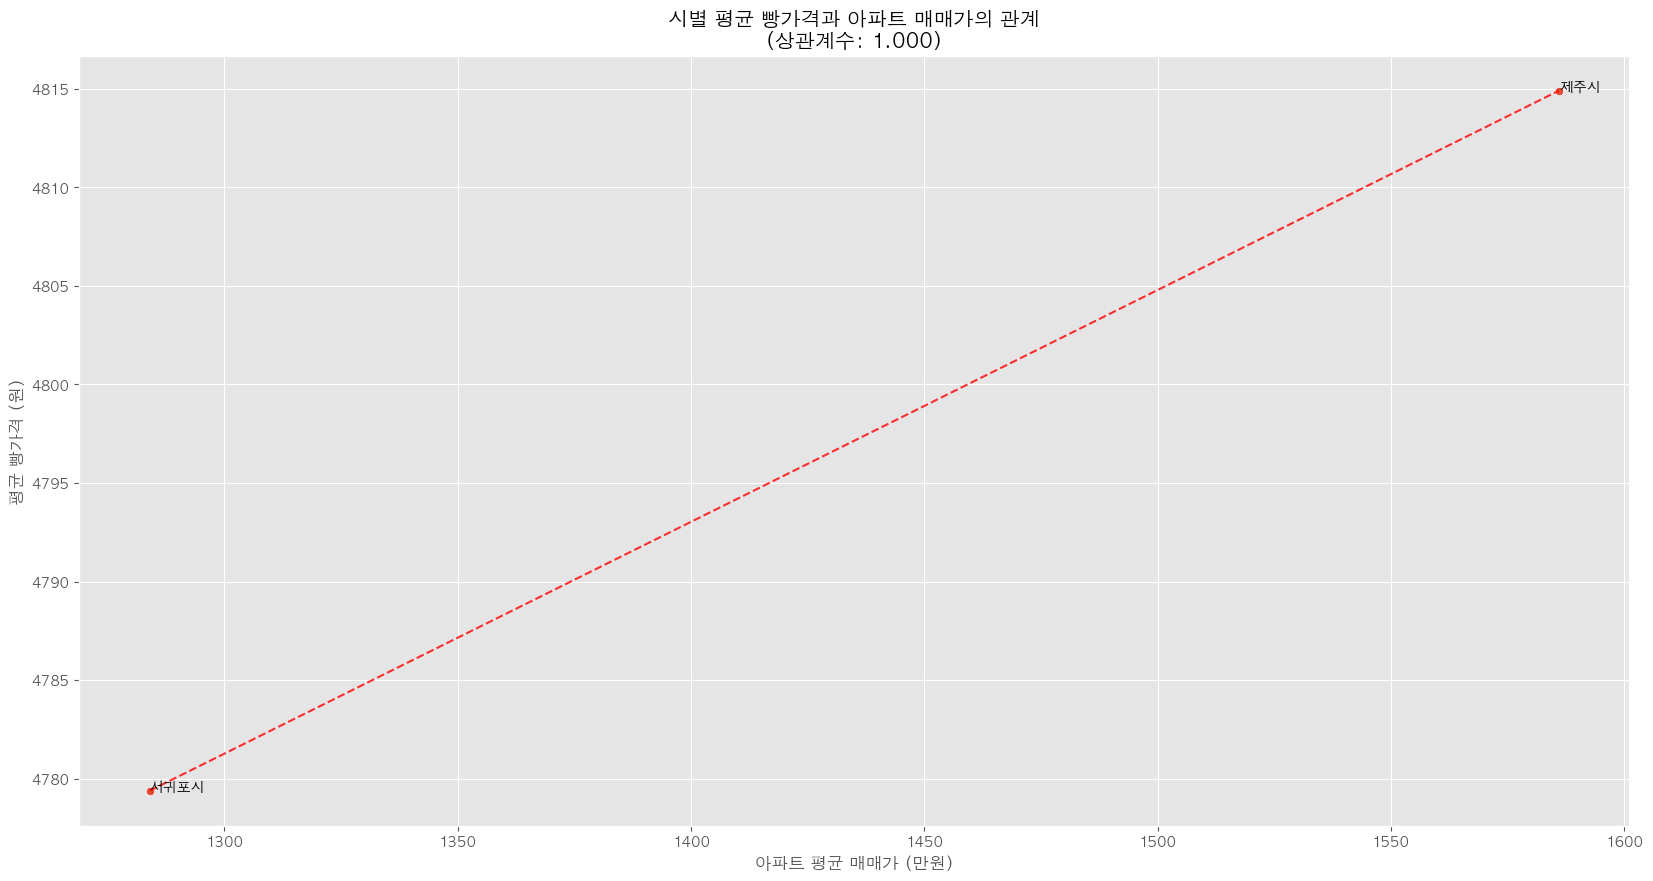

In [15]:
# 1. 구별 평균 빵가격 계산
categories = ['간식빵', '샌드위치류', '샐러드류', '식빵류', '신제품', '크림빵', '파이/패스트리', '피자빵,고로케']
bread_price_by_district = result.groupby('주소')[categories].mean().mean(axis=1).reset_index()
bread_price_by_district.columns = ['구분', '평균_빵가격']
# '충청남도'제거
bread_price_by_district['구분'] = bread_price_by_district['구분'].str.replace('제주특별자치도', '').str.strip()

# 아파트 가격 데이터 전처리
apt_price = pd.read_csv('anal_jeju/jeju_APT_PRICE.csv')
# '제주특별자치도'와 '구' 제거
apt_price['구분'] = apt_price['구분'].str.replace('제주특별자치도', '').str.strip()

apt_price['매매'] = pd.to_numeric(apt_price['매매'].str.replace(',', ''), errors='coerce')
apt_price = apt_price.dropna()  # 결측치 제거


# 데이터 확인
print("전처리 후 구별 빵가격 데이터:")
print(bread_price_by_district)
print("\n전처리 후 아파트 가격 데이터:")
print(apt_price)

# 데이터 병합
merged_df = pd.merge(bread_price_by_district, apt_price[['구분', '매매']], on='구분', how='inner')
print("\n병합된 데이터:")
print(merged_df)

# 시각화
if not merged_df.empty:
    plt.figure(figsize=(20, 10))
    sns.scatterplot(data=merged_df, x='매매', y='평균_빵가격')
    
    # 추세선 추가
    x = merged_df['매매'].values
    y = merged_df['평균_빵가격'].values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--", alpha=0.8)
    
    # 각 점에 구 이름 표시
    for idx, row in merged_df.iterrows():
        plt.annotate(row['구분'], (row['매매'], row['평균_빵가격']))
    
    correlation = merged_df['평균_빵가격'].corr(merged_df['매매'])
    plt.title(f'시별 평균 빵가격과 아파트 매매가의 관계\n(상관계수: {correlation:.3f})')
    plt.xlabel('아파트 평균 매매가 (만원)')
    plt.ylabel('평균 빵가격 (원)')

    print(f"\n상관계수: {correlation:.3f}")
    if correlation > 0:
        print("양의 상관관계가 있습니다: 아파트 가격이 높은 시일수록 빵 가격도 높은 경향이 있습니다.")
    else:
        print("음의 상관관계가 있습니다: 아파트 가격이 높은 시일수록 빵 가격이 낮은 경향이 있습니다.")